In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from linear_genetic_programming.lgp_classifier import LGPClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import seaborn as sns
%matplotlib inline
from DataPreprocessing import DataPreprocessing

In [2]:
sns.set()

In [3]:
from linear_genetic_programming.lgp_classifier import LGPClassifier
from DataPreprocessing import DataPreprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import jaccard_score
import pandas as pd
import re
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import numpy as np
import itertools
from scipy.sparse import csr_matrix
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from matplotlib.pyplot import figure

In [4]:
# import warnings
# warnings.filterwarnings('ignore')
# %matplotlib widget
# %matplotlib notebook
%matplotlib inline
sns.set()
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


In [5]:
# Dr. Steffany data New Preprocessing
# 1: control, 0: case
# path2pickle = '../dataset/lgp702SteffanyNew.pkl'
# df = pd.read_csv('../dataset/Discovery_Cohort2020_08_25_forTing_imputed_fifth_min.csv')
path2pickle = '../dataset/DLB_sub_lgp.pkl'
df = pd.read_csv('../dataset/sub_DLB_metabolomics.csv')
names = df.columns[5:]
y = df['Diagnosis'].to_numpy()
y = np.where(y == 'DLB', 0, y)
y = np.where(y == 'CTRL', 1, y)
y = y.tolist()
X = df.iloc[:, 5:].to_numpy()
scaler=MinMaxScaler((-1,1))
X = scaler.fit_transform(X)

In [6]:
# preprocess data
df_disease = df[df['Diagnosis'] == 'DLB']
df_ctrl = df[df['Diagnosis'] == 'CTRL']

y_disease = df_disease['Diagnosis'].to_numpy()
y_disease = np.where(y_disease == 'DLB', 0, y_disease)
y_disease = np.where(y_disease == 'CTRL', 1, y_disease)
# y_disease = y_disease.tolist()

y_ctrl = df_ctrl['Diagnosis'].to_numpy()
y_ctrl = np.where(y_ctrl == 'DLB', 0, y_ctrl)
y_ctrl = np.where(y_ctrl == 'CTRL', 1, y_ctrl)
y_ctrl = y_ctrl.tolist()

X_disease = df_disease.iloc[:, 5:].to_numpy()
X_ctrl = df_ctrl.iloc[:, 5:].to_numpy()
scaler = MinMaxScaler((-1, 1))
X_disease = scaler.fit_transform(X_disease)
X_ctrl = scaler.fit_transform(X_ctrl)

In [7]:
# # normalize df
# df[df.columns[5:]] = scaler.fit_transform(df[df.columns[5:]])

In [8]:
# df['Diagnosis'] = df['Diagnosis'].replace(['DLB'], 0)
# df['Diagnosis'] = df['Diagnosis'].replace(['CTRL'], 1)

In [9]:
def load_model():
	lgp_models = LGPClassifier.load_model(path2pickle)
	model_list_raw = [i for i in lgp_models]
	return model_list_raw
model_list_raw = load_model()


In [10]:
# only counting disease samples
only_disease = False

In [11]:
model_list_raw[80].predict(X)


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1], dtype=int64)

In [12]:
from clustering_program_utils import convert_program_str_repr
# preprocessing raw list
accuracy = []
raw_model_list = []
sample_list = [] # record overlapping samples
for m in model_list_raw:
	y_pred = m.predict(X)
	score = accuracy_score(y, y_pred)
	if m.testingAccuracy > 0.75: #only filter
		raw_model_list.append(m)
		accuracy.append(score)
		if only_disease:
			temp_y = np.array(y)
			only_index = np.argwhere(temp_y==0).flatten()
			temp_y = temp_y[only_index]
			temp_y_pred = y_pred[only_index]
			sample_list.append(np.argwhere(temp_y==temp_y_pred).flatten())
		else:
			sample_list.append(np.argwhere(y==y_pred).flatten())

Biclustering experiment

In [13]:
from sklearn.cluster import SpectralBiclustering
biclustering_matrix = np.zeros( (len(raw_model_list), X_disease.shape[0] ))

for row, program in enumerate(raw_model_list):
		biclustering_matrix[row, :] = program.predict_proba(X_disease)[:,1]

model = SpectralBiclustering(n_clusters=2, method='log', random_state=0)
model.fit(biclustering_matrix)

SpectralBiclustering(method='log', n_clusters=2, random_state=0)

In [14]:
# model.row_labels_

In [15]:
unique, counts = np.unique(model.column_labels_, return_counts=True)
dict(zip(unique, counts))


{0: 26, 1: 23}

In [16]:
# filter using clustering
model_list = [i for c, i in enumerate(raw_model_list) if model.row_labels_[c] == 0]

In [17]:
accuracy = [i for c, i in enumerate(accuracy) if model.row_labels_[c] == 0]


In [18]:
len(model_list)

282

In [19]:
models_unfiltered = raw_model_list

In [20]:
import copy
import re
def calculate_featureList_and_calcvariableList(raw_model_list):
    numOfVariable = raw_model_list[0].numberOfVariable
    feature_list = []
    program_eff_f_list = []
    for i in raw_model_list:
        feature_list.append(re.findall(r'r\d+', i.bestEffProgStr_))
        program_eff_f_list.append(i.bestEffProgStr_.count('\n'))
    calculation_variable_list = copy.deepcopy(feature_list)  # raw list for later usage
    # processing raw list to get calculation_variable_list
    i = 0
    while i < len(calculation_variable_list):
        j = 0
        program = calculation_variable_list[i]
        while j < len(program):
            if int(calculation_variable_list[i][j][1:]) > numOfVariable:  # remove calculation variable
                del calculation_variable_list[i][j]
            else:
                calculation_variable_list[i][j] = int(calculation_variable_list[i][j][1:])
                j += 1  # ONLY INCREMENT HERE
        i += 1
    i = 0
    # processing raw list to get feature_list
    while i < len(feature_list):
        j = 0
        program = feature_list[i]
        while j < len(program):
            if int(feature_list[i][j][1:]) < numOfVariable:  # remove calculation variable
                del feature_list[i][j]
            else:
                feature_list[i][j] = int(feature_list[i][j][1:]) - numOfVariable
                j += 1  # ONLY INCREMENT HERE
        i += 1
	        # self.calculation_variable_list = calculation_variable_list
    return np.array(feature_list)

# num_to_name = {'AD':0, 'Normal':1}
# y_test = [num_to_name[i] for i in y_test]

In [21]:
feature_list = calculate_featureList_and_calcvariableList(models_unfiltered)
accuracy_list =  [ m.testingAccuracy for m in models_unfiltered]

C:\Users\10455\anaconda3\envs\lgp\lib\site-packages\ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [22]:
eff_f_list = [len(i) for i in feature_list]
eff_f_list = np.array(eff_f_list)

In [23]:
index = np.where(eff_f_list==0)
eff_f_list = np.delete(eff_f_list, index)
accuracy_list = np.delete(accuracy_list, index)

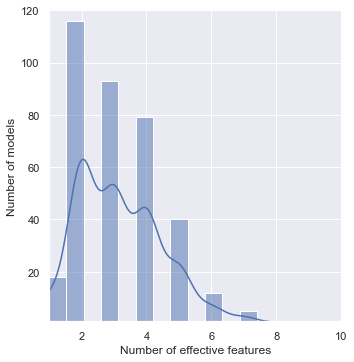

In [24]:
ax = sns.displot(eff_f_list , kde=True)
ax.set(xlabel='Number of effective features', ylabel='Number of models')
ax.set(xlim=(1,10),ylim=(1,120))
plt.gcf().subplots_adjust(bottom=0.1)
plt.savefig('len.tif', dpi=300)
plt.show()

In [25]:
# len(models_filtered)
len(models_unfiltered)

365

In [26]:
# F1 score
f1_scores = [m.validationScores['f1'] for m in models_unfiltered]

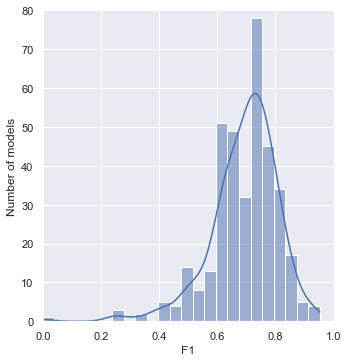

In [27]:
ax = sns.displot(f1_scores, kde=True)
ax.set(xlabel='F1', ylabel='Number of models')
ax.set(xlim=(0,1),ylim=(0,80))
plt.gcf().subplots_adjust(bottom=0.1)
plt.savefig('f1.tif', dpi=300)

plt.show()

In [28]:
auc = [ m.validationScores['auc'] for m in models_unfiltered]

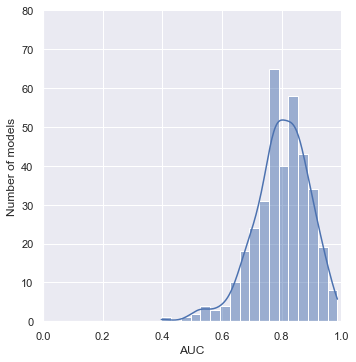

In [29]:
ax = sns.displot(auc, kde=True)
ax.set(xlabel='AUC', ylabel='Number of models')
ax.set(xlim=(0,1),ylim=(0,80))
plt.gcf().subplots_adjust(bottom=0.1)
plt.savefig('auc.tif', dpi=300)
plt.show()

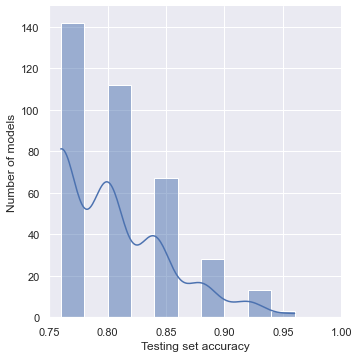

In [30]:
ax = sns.displot(accuracy_list, kde=True)
ax.set(xlabel='Testing set accuracy', ylabel='Number of models')
ax.set(xlim=(0.75,1),ylim=(0,150))
plt.gcf().subplots_adjust(bottom=0.1)
plt.savefig('testing_acc.tif', dpi=300)
plt.show()


In [31]:
# from sklearn.metrics import plot_roc_curve
# import matplotlib.pyplot as plt
#
# # ax = plt.gca()
# # for i in models_unfiltered:
# # 	plot_roc_curve(i, X_test, y_test, ax=ax)
# plot_roc_curve(models_unfiltered[0], X_test, y_test)

# num_to_name = {'AD':1, 'Normal':0}
# y_test = [num_to_name[i] for i in y_test]

In [32]:

# draw complete

C:\Users\10455\anaconda3\envs\lgp\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


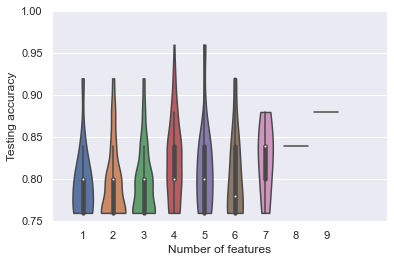

In [33]:
# ax = sns.stripplot(eff_f_list, accuracy_list, size=2)
ax =  sns.violinplot(eff_f_list, accuracy_list, cut=0)
ax.set(xlabel='Number of features', ylabel='Testing accuracy')
ax.set(xlim=(-1,10),ylim=(0.75,1))
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig('f_vs_acc.tif', dpi=300)
plt.show()

In [34]:
from scipy.stats import pearsonr
corr, pvalue = pearsonr(eff_f_list, accuracy_list)
print('Pearsons correlation: %.3f, p value: %.3f' % (corr, pvalue))

Pearsons correlation: 0.187, p value: 0.000


In [35]:
from collections import Counter
from functools import reduce
from operator import add
def get_occurrence_from_feature_list_given_length(given_length, feature_list):
    if given_length == 'All':
        element = feature_list.tolist()
        rank = Counter(reduce(add, element)) # flatten list and count
    else:
        element = np.asarray([i for i in feature_list if len(i) == given_length])
        rank = Counter(element.flatten())
    if len(element) == 0:
        raise ValueError("There is no program in this length")
    features, num_of_occurrences = zip(*rank.most_common())
    return features, num_of_occurrences, len(element)

In [36]:
features, num_of_occurrences, cur_feature_num = get_occurrence_from_feature_list_given_length('All', feature_list)

In [37]:
features = [names[i] for i in features]

In [38]:
df_f_rank = pd.DataFrame({'features': features, 'num_of_occurrences': num_of_occurrences})


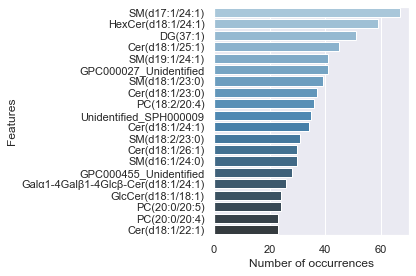

In [39]:
feature_importance = sns.barplot(x='num_of_occurrences', y='features',
                                 data=df_f_rank.iloc[:20, :], palette="Blues_d")
plt.tight_layout()
feature_importance.set(xlim=(0,70))
feature_importance.set(xlabel='Number of occurrences', ylabel='Features')
plt.savefig('f_rank.tif', dpi=300)
plt.show()

In [40]:
# difference coefficient
from differential_coeffcient import get_diff_coefficient
diff_coe, corr_df_control, corr_df0_case = get_diff_coefficient()




clustering experiment

In [41]:
feature_list = np.asarray(feature_list)

In [42]:
feature_dimension = raw_model_list[0].numberOfInput
y = np.array(y)

In [43]:
feature_dimension
# matrix_f = np.zeros((len(raw_model_list), len(raw_model_list)), dtype=float)

50

In [44]:
feature_X = []
for row in range(len(raw_model_list)):
		binary_eff_f1 = np.zeros(feature_dimension, dtype=int)
		binary_eff_f1[feature_list[row]] = 1
		feature_X.append(binary_eff_f1)

In [45]:
distance_metric = 'hamming'
from sklearn import metrics
from sklearn_extra.cluster import KMedoids
score = []
cluster_list = [i for i in range(4, 15)]

for i in cluster_list:
	# --------- KMedoids ------
	kmedoids = KMedoids(n_clusters=i, random_state=0, init='k-medoids++',
	                    metric=distance_metric, method='pam').fit(feature_X)
	cluster_labels = kmedoids.labels_
	# -------------------------

	score.append(metrics.silhouette_score(feature_X, cluster_labels, metric=distance_metric))
print(score)
cluster_num = cluster_list[np.argmin(score)]

[0.13084646790780474, 0.14323895886807078, 0.1429895727121948, 0.15932261465000802, 0.15220395654556707, 0.13430134406518227, 0.14901718217505563, 0.17537415323328098, 0.16068838103852567, 0.15620325841808835, 0.1787429706271538]


In [46]:
kmedoids = KMedoids(n_clusters=cluster_num, random_state=0, init='k-medoids++',
                    metric=distance_metric, method='pam').fit(feature_X)
cluster_labels = kmedoids.labels_

#feature_X matrix_f

from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2, metric = "precomputed").fit_transform(matrix_f)
tsne = TSNE(n_components=2, metric = distance_metric, perplexity=30, learning_rate=50).fit_transform(feature_X)

In [47]:
dftsne = pd.DataFrame(tsne)
dftsne['cluster'] = cluster_labels
dftsne.columns = ['x1','x2','cluster']

In [48]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=3)
pca.fit(feature_X)
pca_X = pca.transform(feature_X)


<AxesSubplot:>

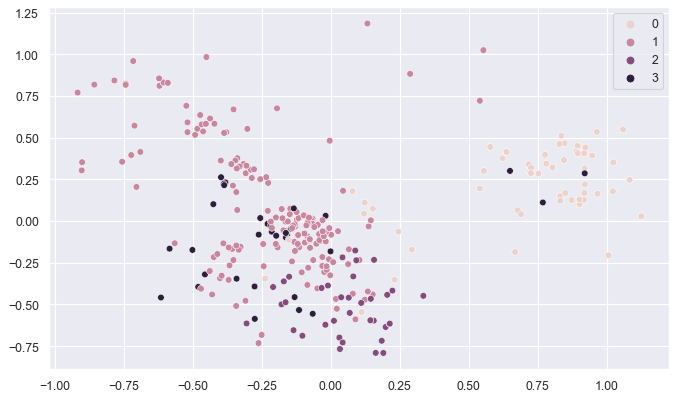

In [49]:
figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
# sns.scatterplot(x= pca_X[:, 0], y = pca_X[:, 1], hue = cluster_labels)
sns.scatterplot(x= pca_X[:, 0], y = pca_X[:, 1], hue = cluster_labels)

In [50]:
len(model.row_labels_)

365

command run tensorboard
tensorboard --logdir log

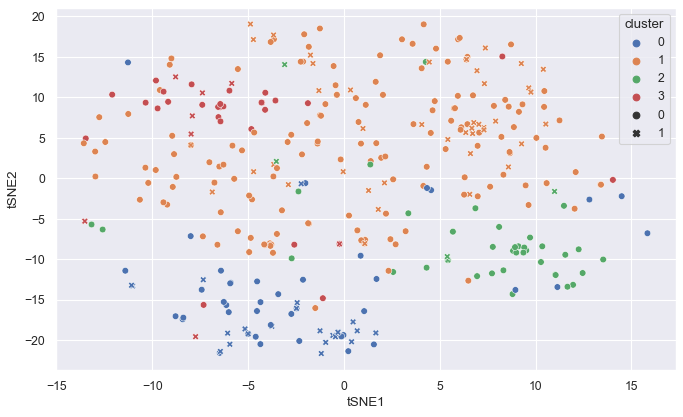

In [51]:
figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.scatterplot(data=dftsne,x='x1',y='x2',hue='cluster',legend="full",alpha=1, palette="deep", style=model.row_labels_)
ax.set_xlabel('tSNE1', fontsize=12)
ax.set_ylabel('tSNE2', fontsize=12)
plt.savefig('clustering_using_features.jpeg', dpi=300, format='JPEG')

Network & differential coefficient

In [52]:
diff_coe_matrix = diff_coe.pivot_table(columns='Source', index='Target', values='Weight')
corr_df_control_matrix = corr_df_control.pivot_table(columns='Source', index='Target', values='Weight')
corr_df0_case_matrix = corr_df0_case.pivot_table(columns='Source', index='Target', values='Weight')

In [53]:
diff_coe_matrix = diff_coe_matrix.round(2)
corr_df_control_matrix = corr_df_control_matrix.round(2)
corr_df0_case_matrix = corr_df0_case_matrix.round(2)

In [110]:
from _processing_funcs import ResultProcessing
from clustering_program_utils import create_network, create_diff_coe_network

result_data = ResultProcessing()
result_data.feature_list = feature_list

# co-occurring
cluster_html = create_network(result_data, top_percentage=10, edge_threshold=5, names=names)



In [111]:
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from _processing_funcs import ResultProcessing
import dash_cytoscape as cyto

cyto.load_extra_layouts()
app = JupyterDash(__name__)

app.layout = cluster_html

# Run app and display result inline in the notebook
app.run_server(mode='external', port=8053)

Dash app running on http://127.0.0.1:8053/


age

In [56]:
cluster_num = 0

In [57]:
df_age = df.sort_values('Age')
df_age = df_age[df['Diagnosis'] == 'DLB']

C:\Users\10455\anaconda3\envs\lgp\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [58]:
df_age.iloc[0][4]


55

In [59]:
len(model.column_labels_)

49

In [60]:
ages = []
for c, i in enumerate(model.column_labels_):
    if i == cluster_num:
        ages.append(df_age.iloc[c][4])

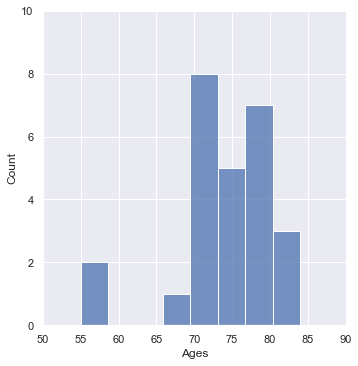

In [61]:
ax = sns.displot(ages)
ax.set_xlabels('Ages')
ax.set(xlim=(50,90), ylim=(0, 10))
# ax.set_ylim(0, 1)
# ax.set_xlabel('age', fontsize=12)
# ax.set_ylabel('correctly classified percentage', fontsize=12)
plt.savefig('age.jpeg', dpi=300, format='JPEG')

In [62]:
gender = []
for c, i in enumerate(model.column_labels_):
    if i == cluster_num:
        gender.append(df_age.iloc[c][3])

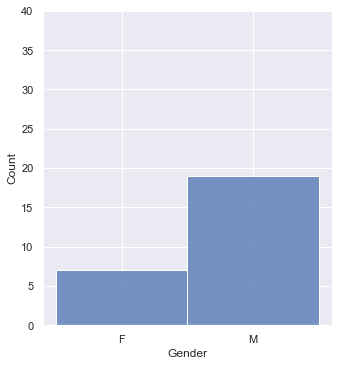

In [63]:
ax = sns.displot(sorted(gender))
ax.set_xlabels('Gender')
ax.set(ylim=(0, 40))
plt.savefig('gender.jpeg', dpi=300, format='JPEG')

In [64]:
unique, counts = np.unique(df_age.iloc[:, 3], return_counts=True)
ori_gender_dic = dict(zip(unique, counts))
ori_gender_dic

{'F': 10, 'M': 39}

In [65]:
temp_a = ['F' for i in range(ori_gender_dic['F'])]
temp_b = ['M' for i in range(ori_gender_dic['M'])]
ori_gender = temp_a + temp_b

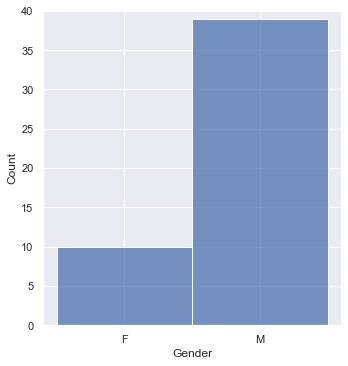

In [66]:
ax = sns.displot(ori_gender)
ax.set_titles('Original Gender Distribution')
ax.set_xlabels('Gender')
ax.set(ylim=(0, 40))
plt.savefig('original_gender_dis.jpeg', dpi=300, format='JPEG')

In [67]:
mmse_df = pd.read_csv('../dataset/MMSE.csv')
mmse_df = mmse_df[df['Diagnosis'] == 'DLB']

In [68]:
mmse_list = []
for c, i in enumerate(model.column_labels_):
    if i == cluster_num:
        mmse_list.append(mmse_df.iloc[c][3])


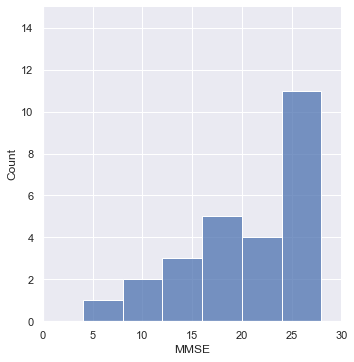

In [69]:
ax = sns.displot(mmse_list)
ax.set_xlabels("MMSE")
ax.set(xlim=(0, 30), ylim=(0,15))
plt.savefig('MMSE_dis.jpeg', dpi=300, format='JPEG')

In [70]:
top20 = df_f_rank.iloc[:20, :]

In [71]:
df.iloc[:, df.columns.isin(top20['features'].values )]

,Galα1-4Galβ1-4Glcβ-Cer(d18:1/24:1),GlcCer(d18:1/18:1),HexCer(d18:1/24:1),Cer(d18:1/23:0),Cer(d18:1/22:1),Cer(d18:1/24:1),Cer(d18:1/25:1),Cer(d18:1/26:1),DG(37:1),PC(18:2/20:4),PC(20:0/20:4),PC(20:0/20:5),SM(d17:1/24:1),SM(d16:1/24:0),SM(d18:1/23:0),SM(d18:2/23:0),SM(d19:1/24:1),GPC000027_Unidentified,GPC000455_Unidentified,Unidentified_SPH000009
0,1268.301631,249.745005,12020.105450,16427.850060,892.800958,27777.49884,1713.143985,935.037444,613.198279,19437.500000,437.625000,9325.000000,4817.500000,4369.802157,25600.000000,17300.000000,4121.250000,90.425000,2343.750000,90.193262
1,752.115272,174.240089,8495.405127,6460.400303,690.870918,16255.31613,711.850355,363.725064,573.915893,6428.016042,267.989181,2437.313910,941.126837,1481.435758,3880.638709,3505.087935,423.677214,25.882513,281.817876,27.650233
2,1032.756489,162.835933,17131.213230,16339.624620,849.465393,32767.91920,1826.243963,939.747142,401.709077,9762.113569,333.955505,3885.368908,3398.306397,3951.004125,11033.781420,9778.511958,1612.646328,32.175675,717.972265,59.452934
3,309.542304,311.633118,24975.110370,9924.337652,1163.956181,17098.58609,637.691656,361.236185,795.026386,3296.539536,155.165899,1187.069366,443.536196,3755.437898,5545.148957,2142.322888,391.503228,15.588072,249.812836,65.060721
4,507.362278,85.531818,12271.043260,7617.034346,755.416595,20904.59870,1194.198887,698.256911,613.426971,13845.663670,884.589900,9065.288207,4951.478054,1590.850665,11515.309360,12197.620310,2711.398731,52.128556,930.987044,39.554979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,1296.964402,372.779665,14649.590590,5359.214333,469.785627,13357.84447,539.252015,438.116596,260.032365,11064.629850,625.102066,3836.509795,2325.726164,3096.770912,9228.713707,4633.406656,1925.834080,57.194220,686.032096,52.077935
120,1074.413292,40.549851,9945.468657,4751.807371,259.094434,12320.91253,463.584263,266.525078,117.594133,7036.845023,301.810010,1810.654220,2131.363937,2020.227467,7394.071582,8279.410631,1041.229375,14.204281,320.006718,39.017096
121,653.995659,45.362047,7482.021211,7772.862645,384.513496,17301.17736,918.582726,461.790150,181.441391,9181.887067,679.008126,2654.510074,2558.202749,2704.896068,6136.551607,4996.222354,1408.171062,84.653898,496.625821,65.782996
122,596.735829,94.663376,10967.962110,3974.790164,240.279961,10297.99045,485.538727,386.856723,285.215828,6258.422267,346.993857,1720.780561,5462.061503,1654.575810,11518.310700,8139.995656,2366.618916,40.109110,702.294667,30.488285


In [72]:
from scipy.stats import pearsonr
pearsonr(mmse_df["MMSE"], mmse_df["Age"])


(-0.11893804065545131, 0.4156629751713328)

In [73]:
df.iloc[:, df.columns.isin(top20['features'].values )]

,Galα1-4Galβ1-4Glcβ-Cer(d18:1/24:1),GlcCer(d18:1/18:1),HexCer(d18:1/24:1),Cer(d18:1/23:0),Cer(d18:1/22:1),Cer(d18:1/24:1),Cer(d18:1/25:1),Cer(d18:1/26:1),DG(37:1),PC(18:2/20:4),PC(20:0/20:4),PC(20:0/20:5),SM(d17:1/24:1),SM(d16:1/24:0),SM(d18:1/23:0),SM(d18:2/23:0),SM(d19:1/24:1),GPC000027_Unidentified,GPC000455_Unidentified,Unidentified_SPH000009
0,1268.301631,249.745005,12020.105450,16427.850060,892.800958,27777.49884,1713.143985,935.037444,613.198279,19437.500000,437.625000,9325.000000,4817.500000,4369.802157,25600.000000,17300.000000,4121.250000,90.425000,2343.750000,90.193262
1,752.115272,174.240089,8495.405127,6460.400303,690.870918,16255.31613,711.850355,363.725064,573.915893,6428.016042,267.989181,2437.313910,941.126837,1481.435758,3880.638709,3505.087935,423.677214,25.882513,281.817876,27.650233
2,1032.756489,162.835933,17131.213230,16339.624620,849.465393,32767.91920,1826.243963,939.747142,401.709077,9762.113569,333.955505,3885.368908,3398.306397,3951.004125,11033.781420,9778.511958,1612.646328,32.175675,717.972265,59.452934
3,309.542304,311.633118,24975.110370,9924.337652,1163.956181,17098.58609,637.691656,361.236185,795.026386,3296.539536,155.165899,1187.069366,443.536196,3755.437898,5545.148957,2142.322888,391.503228,15.588072,249.812836,65.060721
4,507.362278,85.531818,12271.043260,7617.034346,755.416595,20904.59870,1194.198887,698.256911,613.426971,13845.663670,884.589900,9065.288207,4951.478054,1590.850665,11515.309360,12197.620310,2711.398731,52.128556,930.987044,39.554979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,1296.964402,372.779665,14649.590590,5359.214333,469.785627,13357.84447,539.252015,438.116596,260.032365,11064.629850,625.102066,3836.509795,2325.726164,3096.770912,9228.713707,4633.406656,1925.834080,57.194220,686.032096,52.077935
120,1074.413292,40.549851,9945.468657,4751.807371,259.094434,12320.91253,463.584263,266.525078,117.594133,7036.845023,301.810010,1810.654220,2131.363937,2020.227467,7394.071582,8279.410631,1041.229375,14.204281,320.006718,39.017096
121,653.995659,45.362047,7482.021211,7772.862645,384.513496,17301.17736,918.582726,461.790150,181.441391,9181.887067,679.008126,2654.510074,2558.202749,2704.896068,6136.551607,4996.222354,1408.171062,84.653898,496.625821,65.782996
122,596.735829,94.663376,10967.962110,3974.790164,240.279961,10297.99045,485.538727,386.856723,285.215828,6258.422267,346.993857,1720.780561,5462.061503,1654.575810,11518.310700,8139.995656,2366.618916,40.109110,702.294667,30.488285


In [74]:
mmse_df['Sex'] = mmse_df['Sex'].replace(to_replace='M', value=0)
mmse_df['Sex'] = mmse_df['Sex'].replace(to_replace='F', value=1)
import scipy.stats as stats
fvalue, pvalue = stats.f_oneway(mmse_df["MMSE"], mmse_df["Age"], mmse_df['Sex'])


In [75]:
fvalue

2403.5462459307782

In [76]:
pvalue


2.4189371607274625e-111

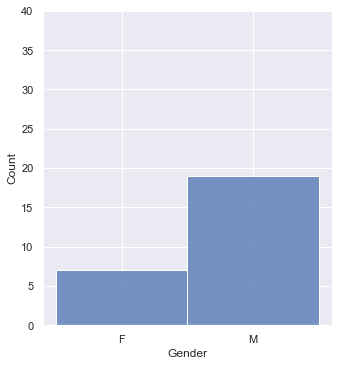

In [77]:
ax = sns.displot(sorted(gender))
ax.set_xlabels('Gender')
ax.set(ylim=(0, 40))

In [78]:
unique, counts = np.unique(df_age.iloc[:, 3], return_counts=True)
ori_gender_dic = dict(zip(unique, counts))
ori_gender_dic

{'F': 10, 'M': 39}

In [79]:
temp_a = ['F' for i in range(ori_gender_dic['F'])]
temp_b = ['M' for i in range(ori_gender_dic['M'])]
ori_gender = temp_a + temp_b

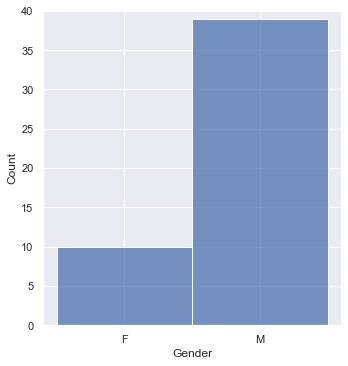

In [80]:
ax = sns.displot(ori_gender)
ax.set_titles('Original Gender Distribution')
ax.set_xlabels('Gender')
ax.set(ylim=(0, 40))

In [81]:
mmse_df = pd.read_csv('../dataset/MMSE.csv')
mmse_df = mmse_df[df['Diagnosis'] == 'DLB']

In [82]:
mmse_list = []
for c, i in enumerate(model.column_labels_):
    if i == cluster_num:
        mmse_list.append(mmse_df.iloc[c][3])


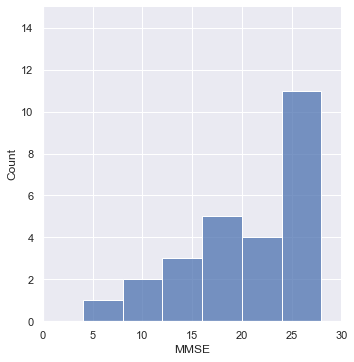

In [83]:
ax = sns.displot(mmse_list)
ax.set_xlabels("MMSE")
ax.set(xlim=(0, 30), ylim=(0,15))

In [84]:
top20 = df_f_rank.iloc[:20, :]

In [85]:
df.iloc[:, df.columns.isin(top20['features'].values )]

,Galα1-4Galβ1-4Glcβ-Cer(d18:1/24:1),GlcCer(d18:1/18:1),HexCer(d18:1/24:1),Cer(d18:1/23:0),Cer(d18:1/22:1),Cer(d18:1/24:1),Cer(d18:1/25:1),Cer(d18:1/26:1),DG(37:1),PC(18:2/20:4),PC(20:0/20:4),PC(20:0/20:5),SM(d17:1/24:1),SM(d16:1/24:0),SM(d18:1/23:0),SM(d18:2/23:0),SM(d19:1/24:1),GPC000027_Unidentified,GPC000455_Unidentified,Unidentified_SPH000009
0,1268.301631,249.745005,12020.105450,16427.850060,892.800958,27777.49884,1713.143985,935.037444,613.198279,19437.500000,437.625000,9325.000000,4817.500000,4369.802157,25600.000000,17300.000000,4121.250000,90.425000,2343.750000,90.193262
1,752.115272,174.240089,8495.405127,6460.400303,690.870918,16255.31613,711.850355,363.725064,573.915893,6428.016042,267.989181,2437.313910,941.126837,1481.435758,3880.638709,3505.087935,423.677214,25.882513,281.817876,27.650233
2,1032.756489,162.835933,17131.213230,16339.624620,849.465393,32767.91920,1826.243963,939.747142,401.709077,9762.113569,333.955505,3885.368908,3398.306397,3951.004125,11033.781420,9778.511958,1612.646328,32.175675,717.972265,59.452934
3,309.542304,311.633118,24975.110370,9924.337652,1163.956181,17098.58609,637.691656,361.236185,795.026386,3296.539536,155.165899,1187.069366,443.536196,3755.437898,5545.148957,2142.322888,391.503228,15.588072,249.812836,65.060721
4,507.362278,85.531818,12271.043260,7617.034346,755.416595,20904.59870,1194.198887,698.256911,613.426971,13845.663670,884.589900,9065.288207,4951.478054,1590.850665,11515.309360,12197.620310,2711.398731,52.128556,930.987044,39.554979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,1296.964402,372.779665,14649.590590,5359.214333,469.785627,13357.84447,539.252015,438.116596,260.032365,11064.629850,625.102066,3836.509795,2325.726164,3096.770912,9228.713707,4633.406656,1925.834080,57.194220,686.032096,52.077935
120,1074.413292,40.549851,9945.468657,4751.807371,259.094434,12320.91253,463.584263,266.525078,117.594133,7036.845023,301.810010,1810.654220,2131.363937,2020.227467,7394.071582,8279.410631,1041.229375,14.204281,320.006718,39.017096
121,653.995659,45.362047,7482.021211,7772.862645,384.513496,17301.17736,918.582726,461.790150,181.441391,9181.887067,679.008126,2654.510074,2558.202749,2704.896068,6136.551607,4996.222354,1408.171062,84.653898,496.625821,65.782996
122,596.735829,94.663376,10967.962110,3974.790164,240.279961,10297.99045,485.538727,386.856723,285.215828,6258.422267,346.993857,1720.780561,5462.061503,1654.575810,11518.310700,8139.995656,2366.618916,40.109110,702.294667,30.488285


In [86]:
from scipy.stats import pearsonr
pearsonr(mmse_df["MMSE"], mmse_df["Age"])


(-0.11893804065545131, 0.4156629751713328)

In [87]:
df.iloc[:, df.columns.isin(top20['features'].values )]

,Galα1-4Galβ1-4Glcβ-Cer(d18:1/24:1),GlcCer(d18:1/18:1),HexCer(d18:1/24:1),Cer(d18:1/23:0),Cer(d18:1/22:1),Cer(d18:1/24:1),Cer(d18:1/25:1),Cer(d18:1/26:1),DG(37:1),PC(18:2/20:4),PC(20:0/20:4),PC(20:0/20:5),SM(d17:1/24:1),SM(d16:1/24:0),SM(d18:1/23:0),SM(d18:2/23:0),SM(d19:1/24:1),GPC000027_Unidentified,GPC000455_Unidentified,Unidentified_SPH000009
0,1268.301631,249.745005,12020.105450,16427.850060,892.800958,27777.49884,1713.143985,935.037444,613.198279,19437.500000,437.625000,9325.000000,4817.500000,4369.802157,25600.000000,17300.000000,4121.250000,90.425000,2343.750000,90.193262
1,752.115272,174.240089,8495.405127,6460.400303,690.870918,16255.31613,711.850355,363.725064,573.915893,6428.016042,267.989181,2437.313910,941.126837,1481.435758,3880.638709,3505.087935,423.677214,25.882513,281.817876,27.650233
2,1032.756489,162.835933,17131.213230,16339.624620,849.465393,32767.91920,1826.243963,939.747142,401.709077,9762.113569,333.955505,3885.368908,3398.306397,3951.004125,11033.781420,9778.511958,1612.646328,32.175675,717.972265,59.452934
3,309.542304,311.633118,24975.110370,9924.337652,1163.956181,17098.58609,637.691656,361.236185,795.026386,3296.539536,155.165899,1187.069366,443.536196,3755.437898,5545.148957,2142.322888,391.503228,15.588072,249.812836,65.060721
4,507.362278,85.531818,12271.043260,7617.034346,755.416595,20904.59870,1194.198887,698.256911,613.426971,13845.663670,884.589900,9065.288207,4951.478054,1590.850665,11515.309360,12197.620310,2711.398731,52.128556,930.987044,39.554979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,1296.964402,372.779665,14649.590590,5359.214333,469.785627,13357.84447,539.252015,438.116596,260.032365,11064.629850,625.102066,3836.509795,2325.726164,3096.770912,9228.713707,4633.406656,1925.834080,57.194220,686.032096,52.077935
120,1074.413292,40.549851,9945.468657,4751.807371,259.094434,12320.91253,463.584263,266.525078,117.594133,7036.845023,301.810010,1810.654220,2131.363937,2020.227467,7394.071582,8279.410631,1041.229375,14.204281,320.006718,39.017096
121,653.995659,45.362047,7482.021211,7772.862645,384.513496,17301.17736,918.582726,461.790150,181.441391,9181.887067,679.008126,2654.510074,2558.202749,2704.896068,6136.551607,4996.222354,1408.171062,84.653898,496.625821,65.782996
122,596.735829,94.663376,10967.962110,3974.790164,240.279961,10297.99045,485.538727,386.856723,285.215828,6258.422267,346.993857,1720.780561,5462.061503,1654.575810,11518.310700,8139.995656,2366.618916,40.109110,702.294667,30.488285


In [88]:
from scipy.stats import zscore
mmse_df['Sex'] = mmse_df['Sex'].replace(to_replace='M', value=0)
mmse_df['Sex'] = mmse_df['Sex'].replace(to_replace='F', value=1)
import scipy.stats as stats
# fvalue, pvalue = stats.f_oneway(mmse_df["MMSE"], mmse_df["Age"], mmse_df['Sex'])
fvalue, pvalue = stats.f_oneway(zscore(mmse_df["MMSE"]), zscore(mmse_df["Age"]))

In [89]:
fvalue

1.7618215260182922e-29

In [90]:
pvalue


1.0

In [91]:
fvalue, pvalue = stats.f_oneway(zscore(mmse_df["MMSE"]), zscore(mmse_df["Age"]), zscore(mmse_df['Sex']))

In [92]:
fvalue


1.1417668643846732e-29

In [93]:
pvalue


1.0

In [94]:
fvalue, pvalue = stats.f_oneway( zscore(mmse_df["Age"]), zscore(mmse_df['Sex']))

In [95]:
fvalue

1.4121197495779347e-29

In [96]:
pvalue


1.0

In [97]:
fvalue


1.4121197495779347e-29

In [98]:
pvalue


1.0

In [99]:
fvalue, pvalue = stats.f_oneway( zscore(mmse_df["Age"]), zscore(mmse_df['Sex']))

In [100]:
fvalue

1.4121197495779347e-29

In [101]:
pvalue


1.0

In [102]:
pvalue


1.0

In [103]:
fvalue, pvalue = stats.f_oneway( zscore(mmse_df["Age"]), zscore(mmse_df['Sex']))

In [104]:
fvalue

1.4121197495779347e-29

In [105]:
pvalue


1.0